In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpmath import * 
plt.style.use('dark_background')

# Define your custom colors
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
    '#FF00FF',  # magenta
    '#FFA500',  # orange
    '#00FFFF',  # cyan
]

# Set the custom color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)


In [2]:

def f2ext(n_phys, n_ext, n_mode, precision=32, cutoff=1e-16):
    mp.dps = precision  # Set decimal precision

    # Adjust domain calculations to cover [-1, 1]
    x_ext = mp.linspace(-1, 1, n_phys + n_ext)  # Extended domain
    # Find physical domain within extended domain, centered
    start_index = (n_ext // 2)
    x_phys = x_ext[start_index:start_index + n_phys]

    # Initialize matrix M using Chebyshev polynomials on physical domain
    M = mp.matrix(n_phys, n_mode)
    for i in range(n_phys):
        for j in range(n_mode):
            M[i, j] = mp.chebyt(j, x_phys[i])  # Use Chebyshev polynomials

    # Compute SVD and inverse using a specified cutoff for singular values
    U, s, Vh = mp.svd(M)
    sinv = mp.diag(s)
    for i in range(min(M.rows, M.cols)):
        sinv[i, i] = 0 if s[i] < cutoff else 1 / s[i]

    Vht   = Vh.transpose_conj()
    Ut    = U.transpose_conj()

    M_inv = Vht * sinv * Ut  # Compute the pseudo-inverse

    dx = x_phys[1] - x_phys[0]
    x_int = mp.matrix(x_phys) + dx/2

    # Reconstruct over the extended domain
    rec = mp.matrix(len(x_int), n_mode)
    for i in range(len(x_int)):
        for j in range(n_mode):
            rec[i, j] = mp.chebyt(j, x_int[i])

    M_int = rec * M_inv  # Interpolation matrix

    return M_int, x_phys, x_int


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


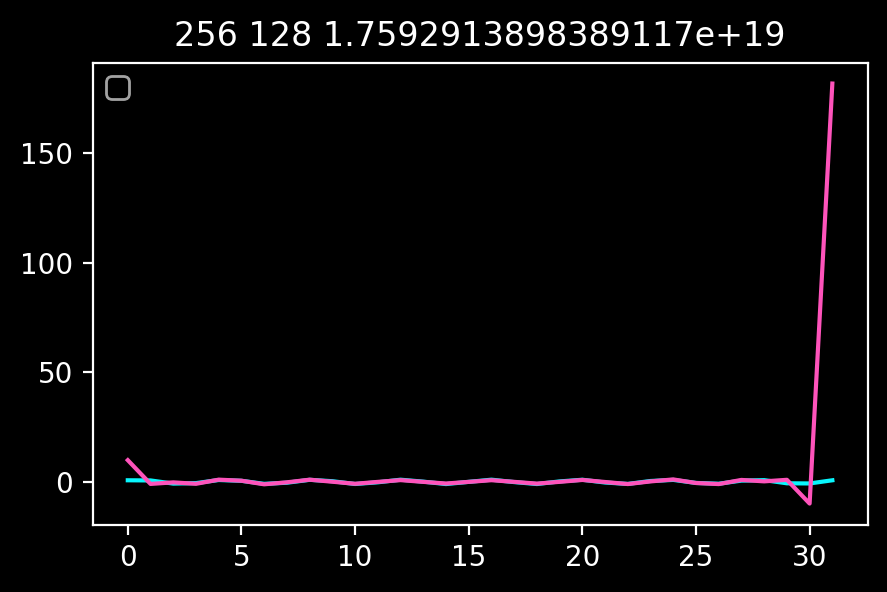

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


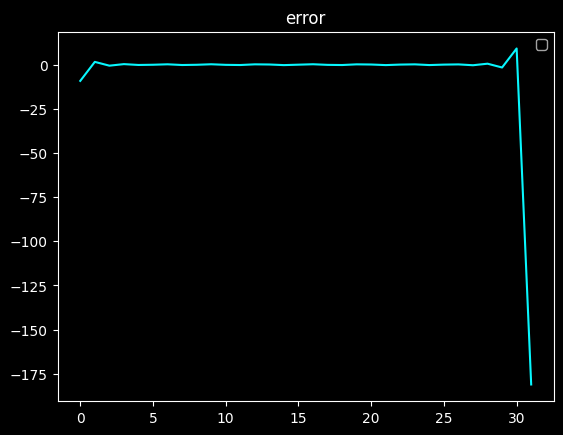

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, k):
    return np.sin(x * 2 * np.pi * k)

N = 32
precisions = [200]
k = 4

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
for cutoff in [1e-8]: 
    for n_ext in [256]:
        for n_mode in [128]: 
            Ms = []
            for precision in precisions:
                M_int, x, x_int = f2ext(n_phys = N, n_ext = n_ext, n_mode=n_mode, precision = precision, cutoff=cutoff)
                Ms.append(M_int)

            # Set values for N and the range of k to test
            k_values = 2 * np.logspace(-2, 1, 20)  # Example range of k from 1 to 100 in logarithmic scale

            # Generate grids
            x      = np.linspace(-1, 1, N)
            dx     = x[1] - x[0] 
            x_eval = -1 + np.arange(N) * dx + dx/2 

            for precision, M in zip(precisions, Ms): 
                # Initialize L1 error list
                l1_errors = []
                M_numpy = np.array(M.tolist()).astype(complex)

                # Compute function values on original and evaluation grids
                f_x      = f(x, k)
                f_x_eval = f(x_eval, k)
                
                # Interpolate using M (placeholder function)
                f_interpolated = M_numpy @ f_x

                plt.title(f"{n_ext} {n_mode} {np.linalg.cond(M_numpy)}")
                plt.plot(f_x_eval)
                plt.plot(f_interpolated)
                plt.legend()
                plt.show()
                plt.plot(f_x_eval - f_interpolated)
                plt.legend()
                plt.title(f'error')
                plt.show()

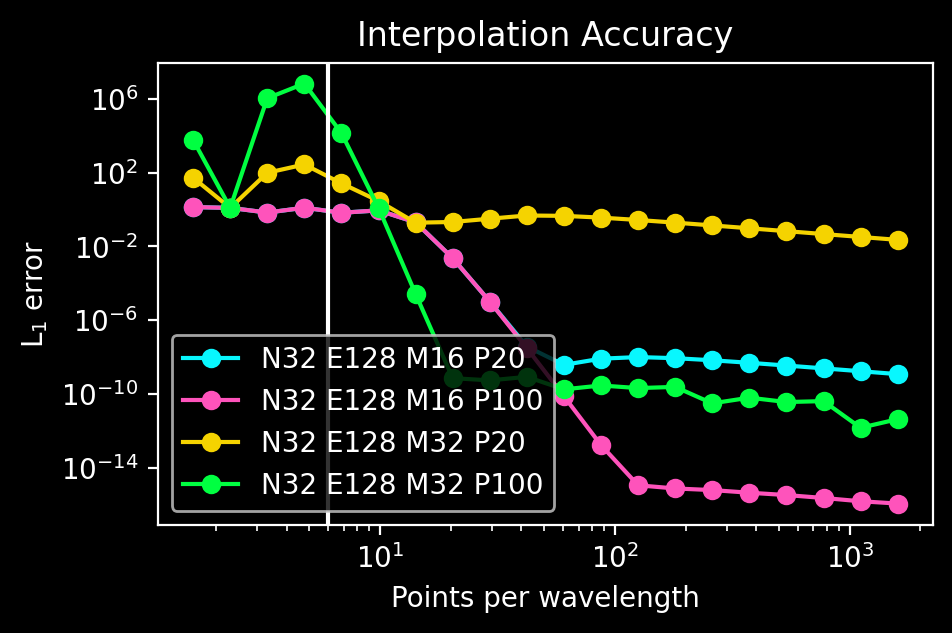

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, k):
    return np.sin(x * 2 * np.pi * k)

N = 32
precisions = [20, 100]


fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
for cutoff in [0]: 
    for n_ext in [128]:
        for n_mode in [16, 32]: 
            Ms = []
            for precision in precisions:
                M_int, x, x_int = f2ext(n_phys = N, n_ext = n_ext, n_mode=n_mode, precision = precision, cutoff=cutoff)
                Ms.append(M_int)

            # Set values for N and the range of k to test
            k_values = 2 * np.logspace(-2, 1, 20)  # Example range of k from 1 to 100 in logarithmic scale

            # Generate grids
            x      = np.linspace(-1, 1, N)
            dx     = x[1] - x[0] 
            x_eval = -1 + np.arange(N) * dx + dx/2 

            for precision, M in zip(precisions, Ms): 
                # Initialize L1 error list
                l1_errors = []
                M_numpy = np.array(M.tolist()).astype(complex)

                for k in k_values:
                    # Compute function values on original and evaluation grids
                    f_x      = f(x, k)
                    f_x_eval = f(x_eval, k)
                    
                    # Interpolate using M (placeholder function)
                    f_interpolated = M_numpy @ f_x
                    
                    # Compute L1 error
                    l1_error = np.mean(np.abs(f_interpolated[:N] - f_x_eval))
                    l1_errors.append(l1_error)

                # Plot results
                plt.loglog(N / k_values, l1_errors, 'o-', label=f"N{N} E{n_ext} M{n_mode} P{precision}")

plt.axvline(6)
plt.legend()
plt.xlabel('Points per wavelength')
plt.ylabel('L$_1$ error')
plt.title(f'Interpolation Accuracy')
plt.show()